In [75]:
#Import Dask

import dask
import cartopy.crs as ccrs
from dask.distributed import Client, progress
client = Client(dashboard_address=':5555')  # set up local cluster on your laptop
client

#Import other necessary modules! 

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import cartopy.feature as cfeature

import scipy.signal as signal

from eofs.xarray import Eof
from eofs.examples import example_data_path


/Users/sunnysharma/opt/anaconda3/lib/python3.9/site-packages/distributed/node.py:180: UserWarning: Port 5555 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 61764 instead
  warnings.warn(


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
ds = xr.open_dataset('https://thredds.rda.ucar.edu/thredds/dodsC/aggregations/g/ds633.1/2/TP',
                     chunks={'time':'500MB'})

variables = ['Total_column_water_vapour_surface_Mixed_intervals_Average',
        'Sea_surface_temperature_surface_Mixed_intervals_Average']
#select the two needed variables every 4th point to get 1 degree resolution
ds = ds[variables].sel(lat=slice(65, -65, 4), lon=slice(120, 300, 4))
print(ds.coords)




Coordinates:
  * lat      (lat) float32 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 297.0 298.0 299.0 300.0
  * time     (time) datetime64[ns] 1979-01-16T12:00:00 ... 2021-12-16T12:00:00
    reftime  (time) datetime64[ns] dask.array<chunksize=(516,), meta=np.ndarray>


In [13]:
wv_mean = ds['Total_column_water_vapour_surface_Mixed_intervals_Average'].mean(dim='time')
sst_mean = ds['Sea_surface_temperature_surface_Mixed_intervals_Average'].mean(dim='time')

sst_month_mean_anom = ds['Sea_surface_temperature_surface_Mixed_intervals_Average'] - sst_mean 

sst_month_mean_anom = sst_month_mean_anom.sel(lat=slice(65, -65), lon=slice(120, 300))


print(wv_mean)

<xarray.DataArray 'Total_column_water_vapour_surface_Mixed_intervals_Average' (
                                                                               lat: 130,
                                                                               lon: 181)>
dask.array<mean_agg-aggregate, shape=(130, 181), dtype=float32, chunksize=(130, 181), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 297.0 298.0 299.0 300.0


In [16]:
ds_land_mask = xr.open_dataset('land_mask.nc')

rename_dict = {'latitude':'lat','longitude':'lon'}
ds_land_mask = ds_land_mask.rename(rename_dict)

ds_land_mask = ds_land_mask['LSM'].sel(lat=slice(65, -65), lon=slice(120, 300))

wv_mean_mask = wv_mean.where(sst_mean.notnull())

wv_month_mean = ds['Total_column_water_vapour_surface_Mixed_intervals_Average'].where(sst_mean.notnull()).sel(lat=slice(65, -65), lon=slice(120, 300))

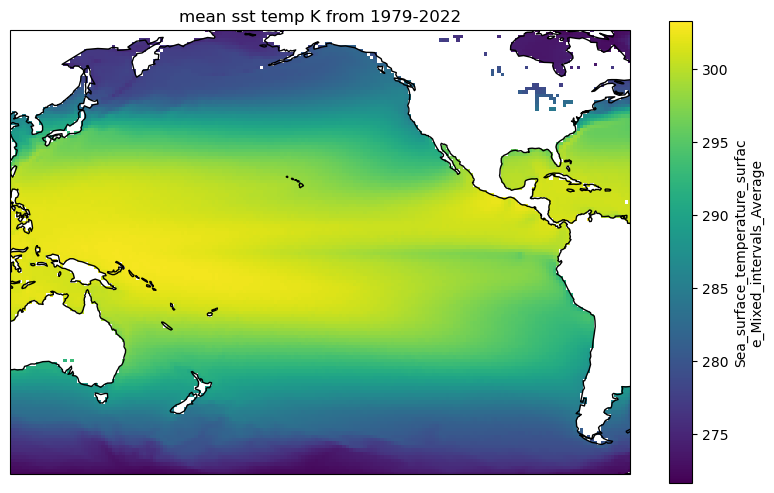

In [15]:
min_lat = -64.25
max_lat = 64.75 
min_lon = 120
max_lon = 300

projection = ccrs.PlateCarree(central_longitude=180)

plt.figure(figsize=(10, 6))
ax = plt.axes(projection=projection)
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
sst_mean.plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('mean sst temp K from 1979-2022')
plt.show()


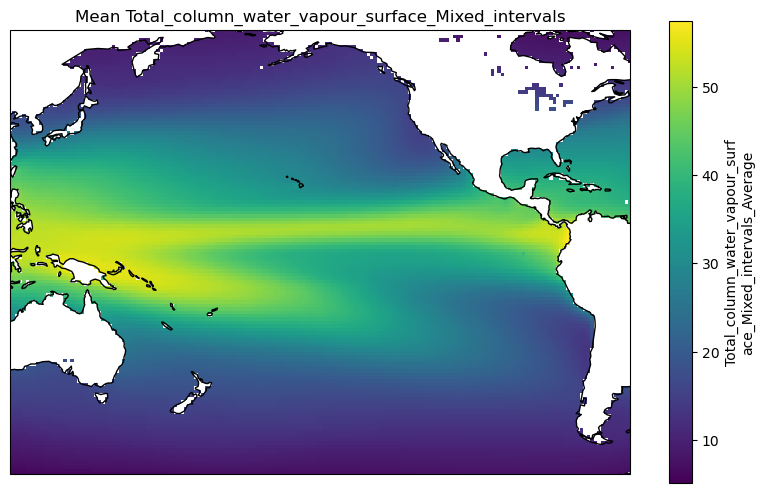

In [8]:
min_lat = -64.25
max_lat = 64.75 
min_lon = 120
max_lon = 300

projection = ccrs.PlateCarree(central_longitude=180)

plt.figure(figsize=(10, 6))
ax = plt.axes(projection=projection)
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
wv_mean_mask.plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Mean Total_column_water_vapour_surface_Mixed_intervals')
plt.show()

In [17]:
# Save monthly means of SST anomalies and total column water vapor. 

wv_month_mean.to_netcdf(path='wv_mean_masked.nc')
sst_month_mean_anom.to_netcdf(path='sst_mean.nc')


In [71]:
#Load in data 
sst_month_mean_anom_raw = xr.open_dataset('sst_mean.nc')
wv_month_mean_raw = xr.open_dataset('wv_mean_masked.nc')

sst_month_mean_anom = sst_month_mean_anom_raw['Sea_surface_temperature_surface_Mixed_intervals_Average']
wv_month_mean = wv_month_mean_raw['Total_column_water_vapour_surface_Mixed_intervals_Average']


In [120]:
#Part two - condition SST data



# Handling infinite values by replacing them with NaN
sst = sst_month_mean_anom.where(np.isfinite(sst_month_mean_anom), np.nan)
# Calculating climatology (monthly means) and anomalies, skipping NaN values
climatology = sst.groupby('time.month').mean('time', skipna=True)
anomalies = sst.groupby('time.month') - climatology
# Detrending the anomalies
def detrend(da):
    da_no_nan = da.fillna(0)
    detrended = xr.apply_ufunc(signal.detrend, da_no_nan, kwargs={'axis': 0}, dask='allowed')
    return detrended.where(~da.isnull())
detrended_anomalies = detrend(anomalies)

# Standardize Le Anomalies 
std_detrend_anom = detrended_anomalies/np.std(detrended_anomalies)



# Condition tcwv data 

# Handling infinite values by replacing them with NaN
tcwv = wv_month_mean.where(np.isfinite(wv_month_mean), np.nan)
# Calculating climatology (monthly means) and anomalies, skipping NaN values
climatology = wv_month_mean.groupby('time.month').mean('time', skipna=True)
anomalies = wv_month_mean.groupby('time.month') - climatology

# Detrending the anomalies
def detrend(da):
    da_no_nan = da.fillna(0)
    detrended = xr.apply_ufunc(signal.detrend, da_no_nan, kwargs={'axis': 0}, dask='allowed')
    return detrended.where(~da.isnull())
wv_detrended_anomalies = detrend(anomalies)

# Standardize Le Anomalies 
wv_detrend_anom = wv_detrended_anomalies/np.std(wv_detrended_anomalies)





Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

I

Text(0.5, 1.0, 'EOF1 expressed as correlation')

/Users/sunnysharma/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/sunnysharma/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/sunnysharma/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


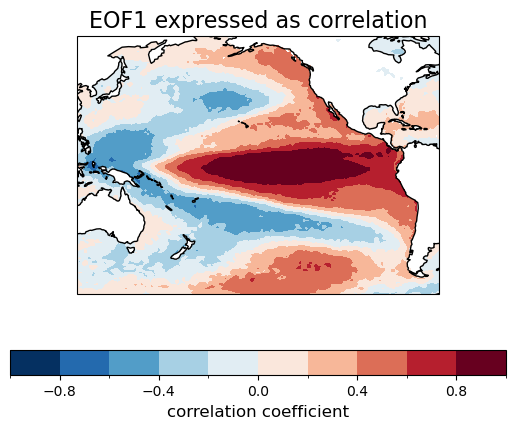

In [97]:
# 3) Perform an EOF analysis (with cosine latitude weighting) on the SST anomalies and plot a map of the first 5 EOFs.

# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(sst_month_mean_anom.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(std_detrend_anom,weights=wgts) 

#Plot first EOF 
eof1 = solver.eofsAsCorrelation(neofs=10)
pc1 = solver.pcs(npcs=10, pcscaling=1)

# Plot the leading EOF expressed as correlation in the Pacific domain.
clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eof1[0].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF1 expressed as correlation', fontsize=16)


Text(0.5, 1.0, 'EOF2 expressed as correlation')

/Users/sunnysharma/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/sunnysharma/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/sunnysharma/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


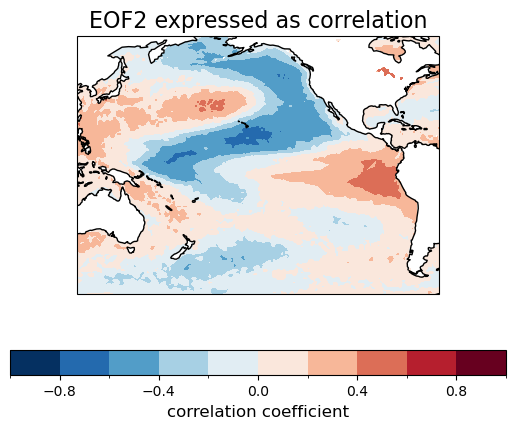

In [98]:
# Plot the leading EOF expressed as correlation in the Pacific domain.
clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eof1[1].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF2 expressed as correlation', fontsize=16)

Text(0.5, 1.0, 'EOF3 expressed as correlation')

/Users/sunnysharma/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/sunnysharma/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/sunnysharma/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


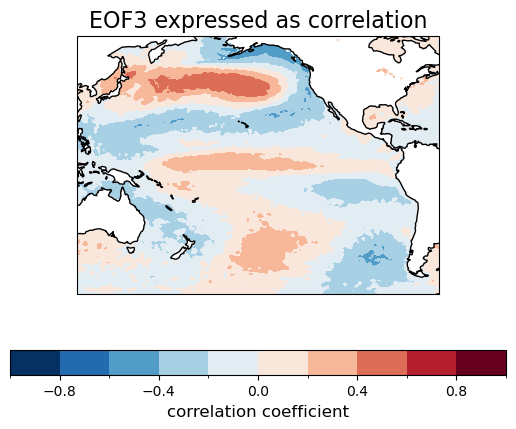

In [99]:
# Plot the leading EOF expressed as correlation in the Pacific domain.
clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eof1[2].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF3 expressed as correlation', fontsize=16)

Text(0.5, 1.0, 'EOF4 expressed as correlation')

/Users/sunnysharma/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/sunnysharma/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/sunnysharma/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


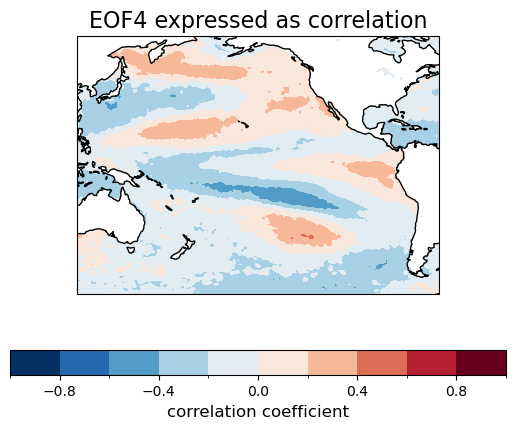

In [100]:
# Plot the leading EOF expressed as correlation in the Pacific domain.
clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eof1[3].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF4 expressed as correlation', fontsize=16)

Text(0.5, 1.0, 'EOF5 expressed as correlation')

/Users/sunnysharma/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/sunnysharma/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/sunnysharma/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


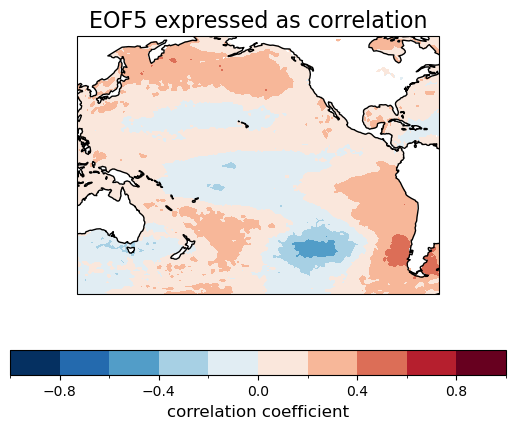

In [106]:
# Plot the leading EOF expressed as correlation in the Pacific domain.
clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eof1[4].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF5 expressed as correlation', fontsize=16)

(4.5431743988515083e-32, 0.2403663101458256)

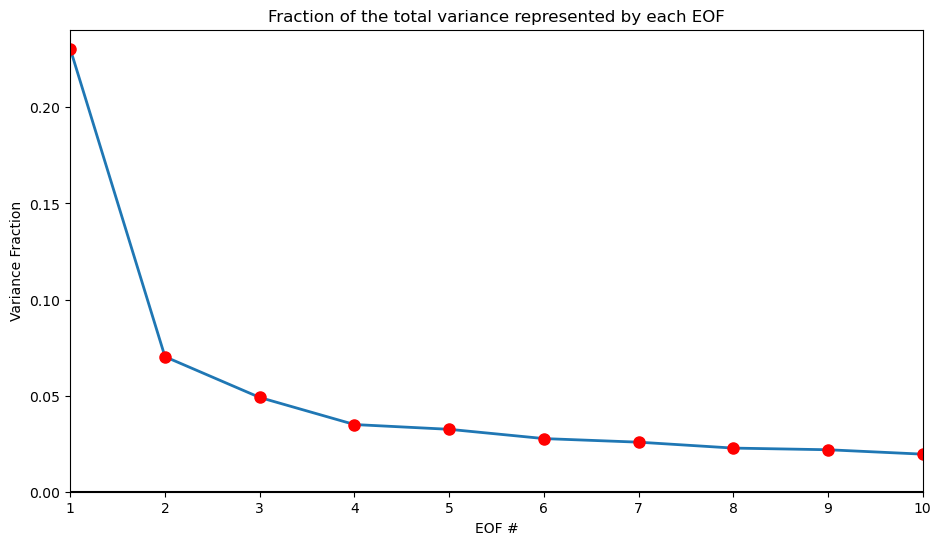

In [104]:
# Part (4) Plot the percent of variance explained by the first 10 EOFs.
# Plot the fraction of variance explained by each EOF
varfrac = solver.varianceFraction()
plt.figure(figsize=(11,6))
eof_num = range(1, 11)
plt.plot(eof_num, varfrac[0:10], linewidth=2)
plt.plot(eof_num, varfrac[0:10], linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 11))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 10)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)

Text(0.5, 1.0, 'Reconstruction of Std. SST Anom from 5 EOFs')

/Users/sunnysharma/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/sunnysharma/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/sunnysharma/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


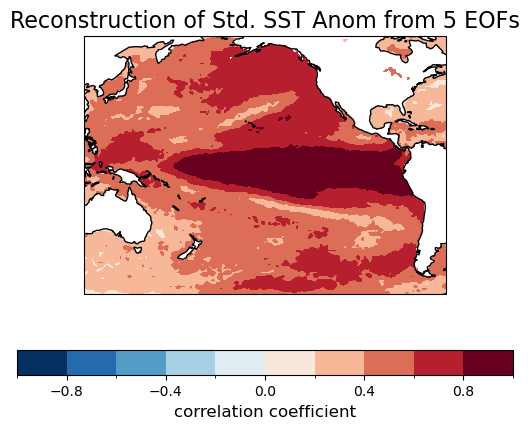

In [117]:
#Part 5: Reconstruct the SST field using the first 5 EOFs and plot a map of the Pearson's correlation coefficient ([xarray.corr](https://docs.xarray.dev/en/stable/generated/xarray.corr.html)) of the reconstructed monthly time series and the "observed" SST time series.

sst_eof = eof1[0]*pc1[:, 0] + eof1[1]*pc1[:, 1] + eof1[2]*pc1[:, 2] + eof1[3]*pc1[:, 3] + eof1[4]*pc1[:, 4] 
pearson_corr = xr.corr(sst_eof,std_detrend_anom, dim='time')

clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = pearson_corr.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('Reconstruction of Std. SST Anom from 5 EOFs', fontsize=16)

Text(0.5, 1.0, 'Pearson Correlation b/w SST EOF1 and std. water vapor anomalies')

/Users/sunnysharma/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/sunnysharma/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/sunnysharma/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


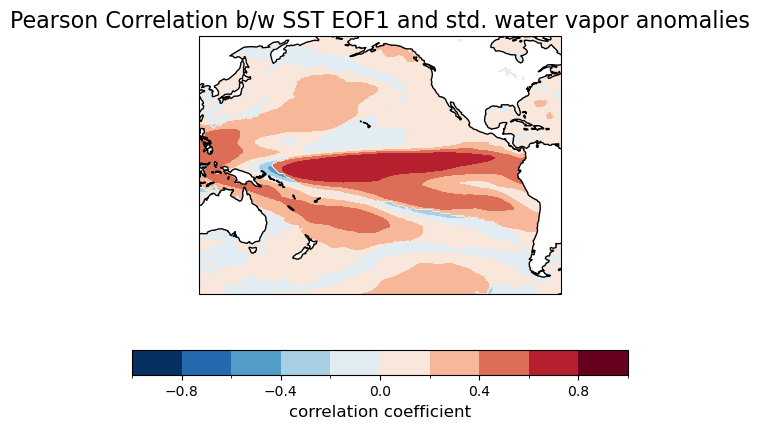

In [123]:
#Part 6) Compute a map of the Pearson's correlation coefficient between SST EOF1 and monthly mean detrended, deseasonalized, and standardized monthly mean precipitation anomalies (don't mask these over land for the plot).
#See anything interesting?

sst_eof = eof1[0]*pc1[:, 0] 
pearson_corr_sst_wv = xr.corr(sst_eof,wv_detrend_anom, dim='time') 

clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = pearson_corr_sst_wv.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('Pearson Correlation b/w SST EOF1 and std. water vapor anomalies', fontsize=16)
